In [1]:
%reload_ext autoreload
%autoreload 2

Failed to read module file 'C:\Python\Python311\Lib\functools.py' for module 'functools': UnicodeDecodeError
Traceback (most recent call last):
  File "c:\Users\Braian\OneDrive\Escritorio\GitHub\CEIA\feinn_project\.venv\Lib\site-packages\IPython\core\extensions.py", line 62, in load_extension
    return self._load_extension(module_str)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Braian\OneDrive\Escritorio\GitHub\CEIA\feinn_project\.venv\Lib\site-packages\IPython\core\extensions.py", line 77, in _load_extension
    mod = import_module(module_str)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Python\Python311\Lib\importlib\__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 1206, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1178, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1142

In this example, we explore the capabilities of FEINN in solving a multimaterial model.

### General Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Mesh definition

In this case, we load a mesh created using SMESH module from Salome Meca platform.

In [3]:
from mesher import Mesh2D

mesh = Mesh2D.from_salome_med(filepath = './MultiMat.med')

Loaded SALOME .med mesh: 861 nodes, 980 elements
Node groups (4): ['left_e', 'right_e', 'bottom_e', 'top_e']
Element groups (14): ['GR_1_all', 'GR_1_bot_s', 'all', 'bot_s', 'GR_1_top_s', 'top_s', 'GR_1_top_e', 'top_e', 'GR_1_bottom_e', 'bottom_e', 'GR_1_right_e', 'right_e', 'GR_1_left_e', 'left_e']


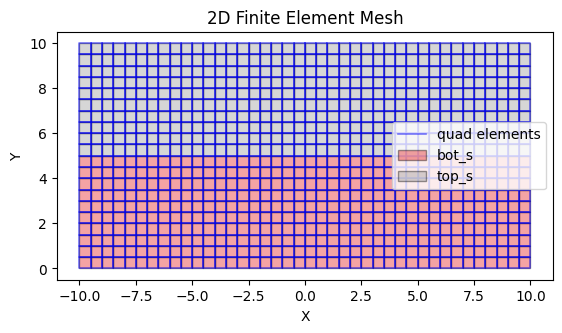

In [4]:
mesh.plot(show_nodes=False, element_groups_to_plot=['bot_s','top_s'])

### Dirichlet boundary conditions

In [5]:
from solver import BoundaryCondition

bcs = {
        'left_e': BoundaryCondition(dof=1, value=0.0),      
        'right_e': BoundaryCondition(dof=1, value=0.0),
        'bottom_e': BoundaryCondition(dof=2, value=0.0),
        }

### Define material

In [6]:
from materials import LinearElastic

mat1 = LinearElastic(emod = 30*1e6, nu = 0.40)
mat2 = LinearElastic(emod = 50*1e6, nu = 0.30)

matfield = {'top_s': mat1, 
            'bot_s': mat2}

### von Neumman boundary conditions

In [7]:
from solver import LineLoad

compresion = {
            'top_e': LineLoad(fx = 0.0, fy = -2*1e6, reference = "global"),
            }


### Model

In [8]:
from solver import NFEA

fem_solver = NFEA(mesh = mesh, 
                      bcs = bcs, 
                      matfld = matfield,
                      line_loads = compresion,
                      verbose = True
                      )



[matfld] Assigned: ['top_s', 'bot_s']
[matfld] All 800 quad elements have assigned material
[line_load] Applied 1 line load groups
[BC] Processed 3 Dirichlet condition(s) → 83 total constraint(s)
[BC] Applied Dirichlet BCs → 83 fixed DOFs


In [9]:
fem_solver.run_complete(nsteps=1)

[Load] Set load factor = 1.0000.
Iter   1 | du error: 1.00e+00  Res error: 1.78e-14  Energetic error: -4.37e-08
Iter   2 | du error: 8.94e-15  Res error: 6.03e-15  Energetic error: -5.46e-24
Converged in 2 iterations


In [10]:
fem_solver.udisp

tensor([-2.0234e-17, -1.4857e-01,  5.9013e-18,  ..., -1.6413e-01,
         1.2864e-17, -1.6413e-01], dtype=torch.float64)

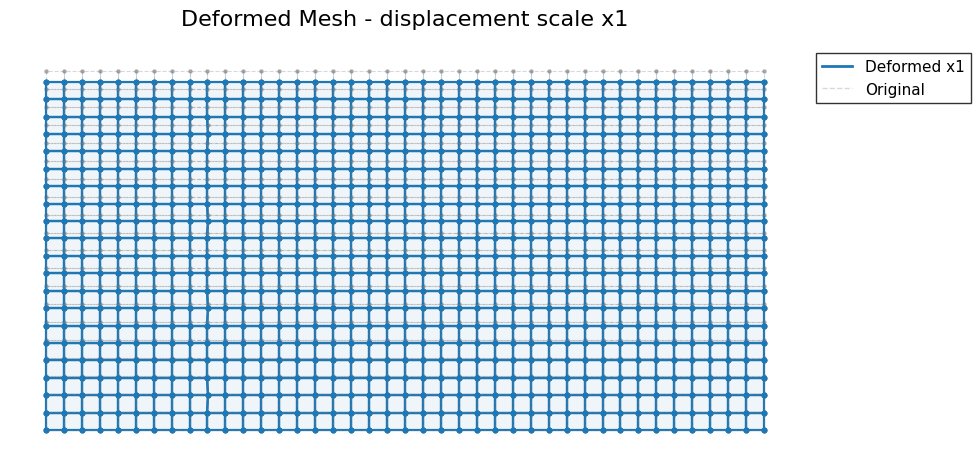

In [11]:
fem_solver.plot_deformed_mesh(scale=1)

In [12]:
from solver import FEINN
from nn_models import mFCNet, FCResNet
import torch.nn as nn

feinn_solver = FEINN(
    mesh=mesh,
    bcs=bcs,
    matfld=matfield,
    line_loads = compresion,
    verbose=False,
    nnet = mFCNet(num_layers=6, num_neurons=64, activation=nn.ReLU, isFourier=True),
    bc_weight=1e6,
    nnet_init = 'xavier',
    )

In [13]:
from types import SimpleNamespace

cfg = SimpleNamespace(**{})

cfg.epochs = 20000
cfg.learning_rate = 1e-2
cfg.lr_min = 1e-5

In [14]:
import torch

optimizer = torch.optim.Adam(
    feinn_solver.nnet.parameters(),
    lr = cfg.learning_rate,
    weight_decay = 0,
  )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max = cfg.epochs,
    eta_min = cfg.lr_min
  )

from trainer import ReLoBraLoBalancer
balancer = ReLoBraLoBalancer(alpha=0.5, rho=0.999, temperature=0.1, lookback_prob=0.05)

# Entrenar
feinn_solver.train(epochs = cfg.epochs,
                   optimizer=optimizer,
                   balancer=balancer,
                   scheduler=scheduler,
                   lbfgs_epochs = 100,
                   warmup = True, 
                   verbose = True)

[FEINN] Starting warmup for zero initial displacement
Warmup loss: 4.75e-02
[FEINN] Warmup completado - salida inicial ≈ 0
[FEINN] Zero-output init: max |u| inicial = 1.64e+00

Epoch 1/20000
Total Loss: 1.029e+05
  Domain: 2.426e+04
  BC:     7.865e+04

Epoch 500/20000
Total Loss: 9.106e+02
  Domain: 7.711e+02
  BC:     2.352e-01

Epoch 1000/20000
Total Loss: 1.739e+02
  Domain: 1.436e+02
  BC:     3.251e-02

Epoch 1500/20000
Total Loss: 5.620e+01
  Domain: 4.532e+01
  BC:     7.697e-03

Epoch 2000/20000
Total Loss: 2.514e+01
  Domain: 2.015e+01
  BC:     5.426e-03

Epoch 2500/20000
Total Loss: 1.582e+01
  Domain: 1.264e+01
  BC:     2.755e-03

Epoch 3000/20000
Total Loss: 8.612e+00
  Domain: 6.988e+00
  BC:     4.133e-03

Epoch 3500/20000
Total Loss: 3.947e+00
  Domain: 3.259e+00
  BC:     2.594e-04

Epoch 4000/20000
Total Loss: 2.485e+00
  Domain: 2.090e+00
  BC:     1.081e-04

Epoch 4500/20000
Total Loss: 2.145e+00
  Domain: 1.848e+00
  BC:     2.098e-04

Epoch 5000/20000
Total Loss

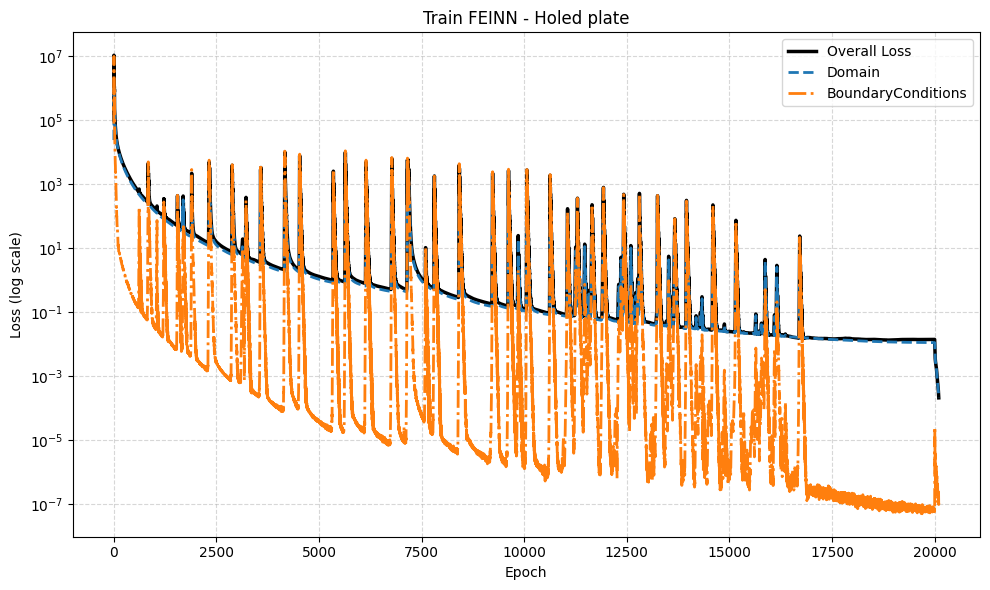

In [15]:
feinn_solver.plot_history(title="Train FEINN - Holed plate")

C:\Users\Braian\OneDrive\Escritorio\GitHub\CEIA\feinn_project\src\evaluator.py:36: RuntimeWarning: divide by zero encountered in divide
  100 * np.abs((self.y_pred - self.y_true) / self.y_true),


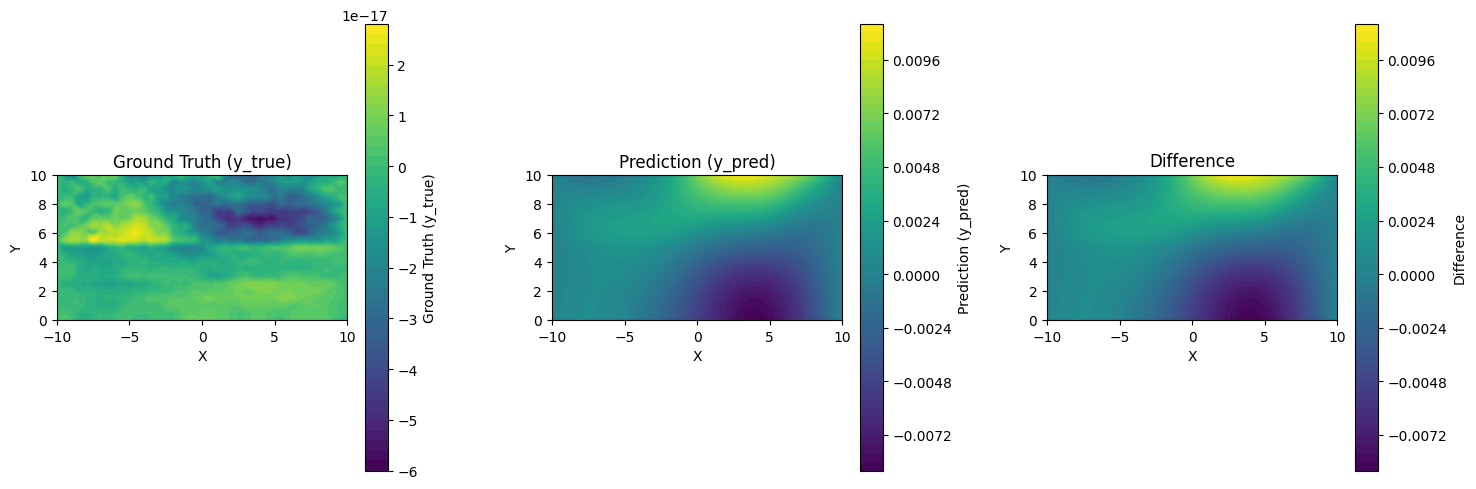

In [16]:
from evaluator import SolutionComparator
comparator = SolutionComparator(mesh, fem_solver.udisp[::2], feinn_solver.udisp[::2])
comparator.plot_comparison(metric='difference')

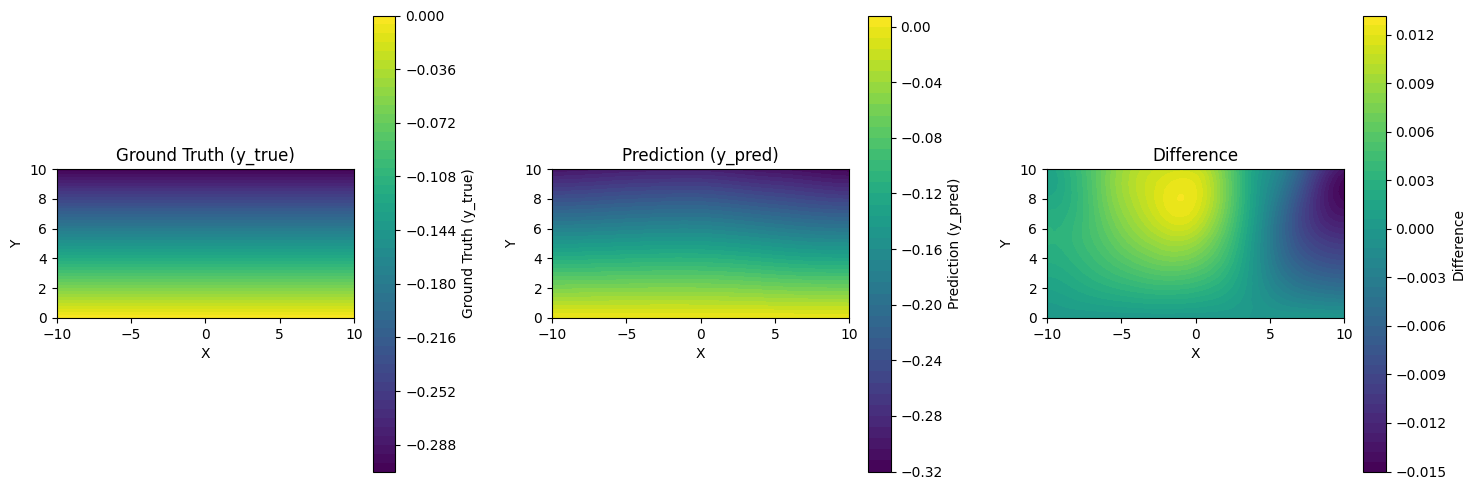

In [17]:
comparator = SolutionComparator(mesh, fem_solver.udisp[1::2], feinn_solver.udisp[1::2])
comparator.plot_comparison(metric='difference')

In [18]:
feinn_solver.train(epochs = 0,
                   lbfgs_epochs = 100,
                   warmup = False, 
                   verbose = True)


Epoch 1/100 (L-BFGS)
Total Loss: 2.072e-04
  Domain: 2.071e-04
  BC:     1.025e-07

Epoch 10/100 (L-BFGS)
Total Loss: 1.659e-04
  Domain: 1.658e-04
  BC:     1.038e-07

Epoch 20/100 (L-BFGS)
Total Loss: 1.423e-04
  Domain: 1.422e-04
  BC:     6.277e-08

Epoch 30/100 (L-BFGS)
Total Loss: 1.236e-04
  Domain: 1.235e-04
  BC:     6.641e-08

Epoch 40/100 (L-BFGS)
Total Loss: 1.123e-04
  Domain: 1.123e-04
  BC:     3.367e-08

Epoch 50/100 (L-BFGS)
Total Loss: 9.791e-05
  Domain: 9.786e-05
  BC:     4.924e-08

Epoch 60/100 (L-BFGS)
Total Loss: 8.562e-05
  Domain: 8.558e-05
  BC:     4.733e-08

Epoch 70/100 (L-BFGS)
Total Loss: 7.410e-05
  Domain: 7.404e-05
  BC:     6.073e-08

Epoch 80/100 (L-BFGS)
Total Loss: 6.582e-05
  Domain: 6.579e-05
  BC:     3.043e-08

Epoch 90/100 (L-BFGS)
Total Loss: 6.067e-05
  Domain: 6.065e-05
  BC:     2.025e-08

Epoch 100/100 (L-BFGS)
Total Loss: 5.916e-05
  Domain: 5.914e-05
  BC:     1.769e-08
 Maximum gradient (Inf-Norm): 4.53e-02


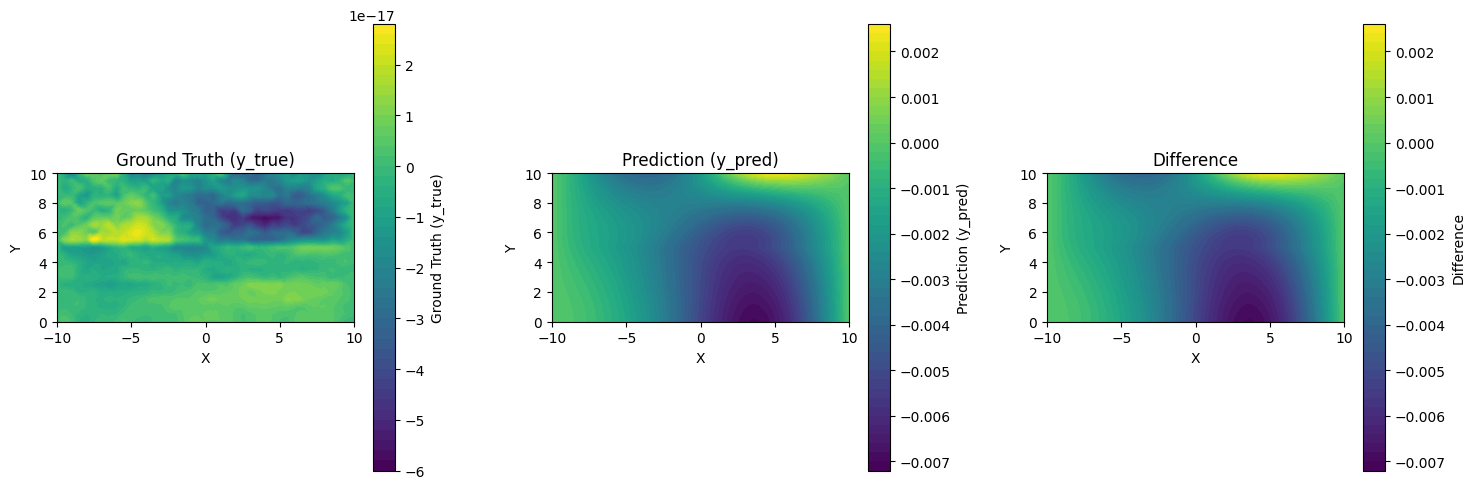

In [20]:
from evaluator import SolutionComparator
comparator = SolutionComparator(mesh, fem_solver.udisp[::2], feinn_solver.udisp[::2])
comparator.plot_comparison(metric='difference')

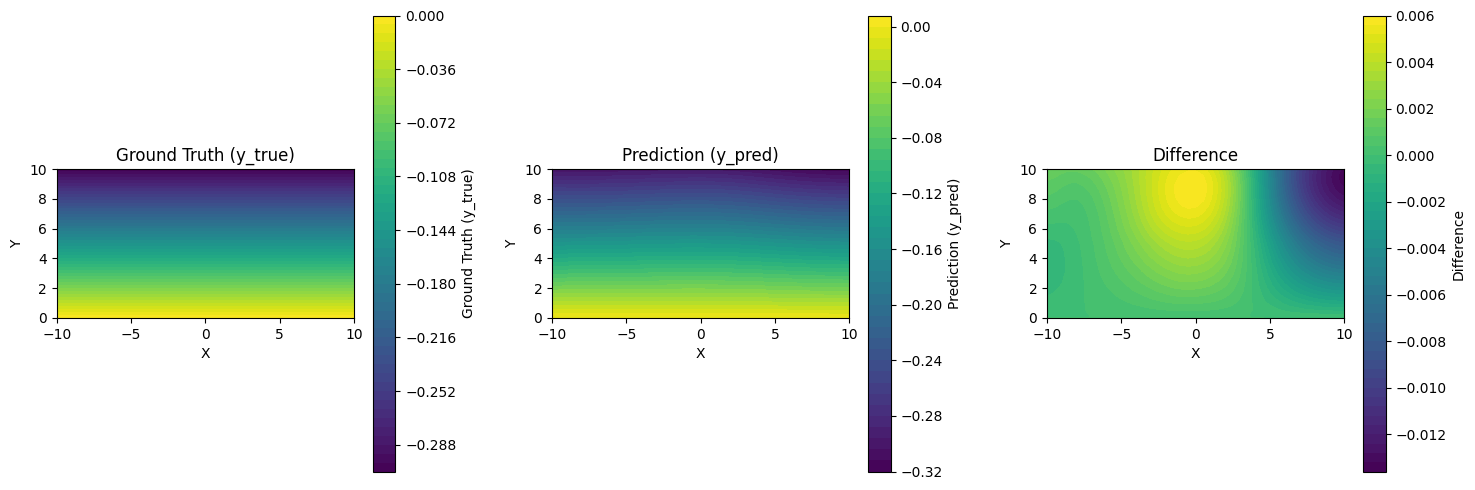

In [21]:
comparator = SolutionComparator(mesh, fem_solver.udisp[1::2], feinn_solver.udisp[1::2])
comparator.plot_comparison(metric='difference')